# CNN   small datasets 학습


- 학습할 Data의 개수가 많지 않을 때 CNN을 통한 모형 학습이 어려울 수 있음
  - 딥러닝은 많은 양의 데이터셋을 이용해 feature engineering 과정 없이 원하는 문제를 해결할 수 있다. => **Point: 많은 데이터 양**
- Data 양이 많지 않아 딥러닝 모델의 학습에 어려움이 있을 때 사용 가능한 방법
    - **Image augmentation 활용**
        - Image에 다양한 효과를 주어 데이터양을 늘린다.
            - Train dataset은 전체 대상 이미지들을 샘플링한 것이기 때문에 모든 형태를 다 가지고 있지 않다. Data augmentation은 train set의 이미지에 다양한 효과를 주어 실제 데이터셋과의 간격을 줄인다.
            - 영상데이터의 경우 각 영상 데이터의 색변경, 이미지잘라내기, 회전시키기, 명암변경 등을 적용하여 이미지들을 추가로 만들어 data의 수를 늘린다.
        - **모델의 Overfitting을 개선시킨다.**
        - pytorch image augmentation을 위한 클래스들
            - https://pytorch.org/vision/stable/transforms.html
    - **Pre-trained network**의 활용한 **Transfer learning (전이학습)**
        - 매우 큰 데이터셋으로 미리 Training한 모델을 이용해 모델을 정의한다.
        - 성능이 좋은모델을 다량의 데이터로 학습시킨 모델을 사용하므로 적은 데이터에도 좋은 성능을 낼 수있다.

# Image Augmentation 예제

In [2]:
import torch
from torchvision import transforms

import cv2
import matplotlib.pyplot as plt

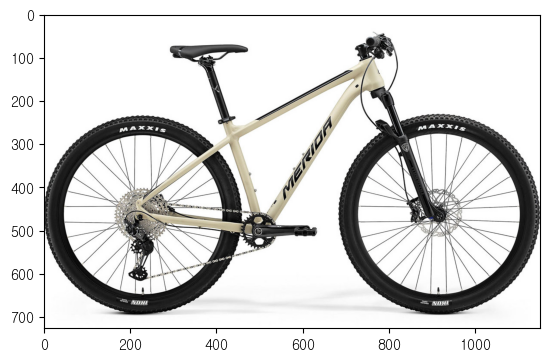

In [32]:
img = cv2.imread('test_img/bicycle.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)

In [33]:
# 이미지 출력 함수
def image_show(img_path, transforms):
    """
    이미지 경로와 transforms를 받아서 적용한뒤 원본이미지와 처리된 이미지를 출력한다.
    transforms는 8번 적용시켜 출력한다.
    [parameter]
        img_path: str - transforms를 적용할 이미지 경로
        transforms: Transforms 객체. 단 ToTensor()가 첫번째 transforms로 정의되 있어야 한다.
    """
    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    plt.rcParams['font.family'] = 'gulim'
    
    col = 6
    row = 6

    plt.figure(figsize=(15, 12))
    plt.subplot(col, row, 1)
    plt.imshow(img)
    plt.title('원본')
    plt.axis('off')

    for i in range(2, col*row+1):
        result_img = transforms (img)
        plt.subplot(col, row, i)    
        plt.imshow(result_img.permute(1, 2, 0))
        plt.axis('off')

    plt.tight_layout()
    plt.show()

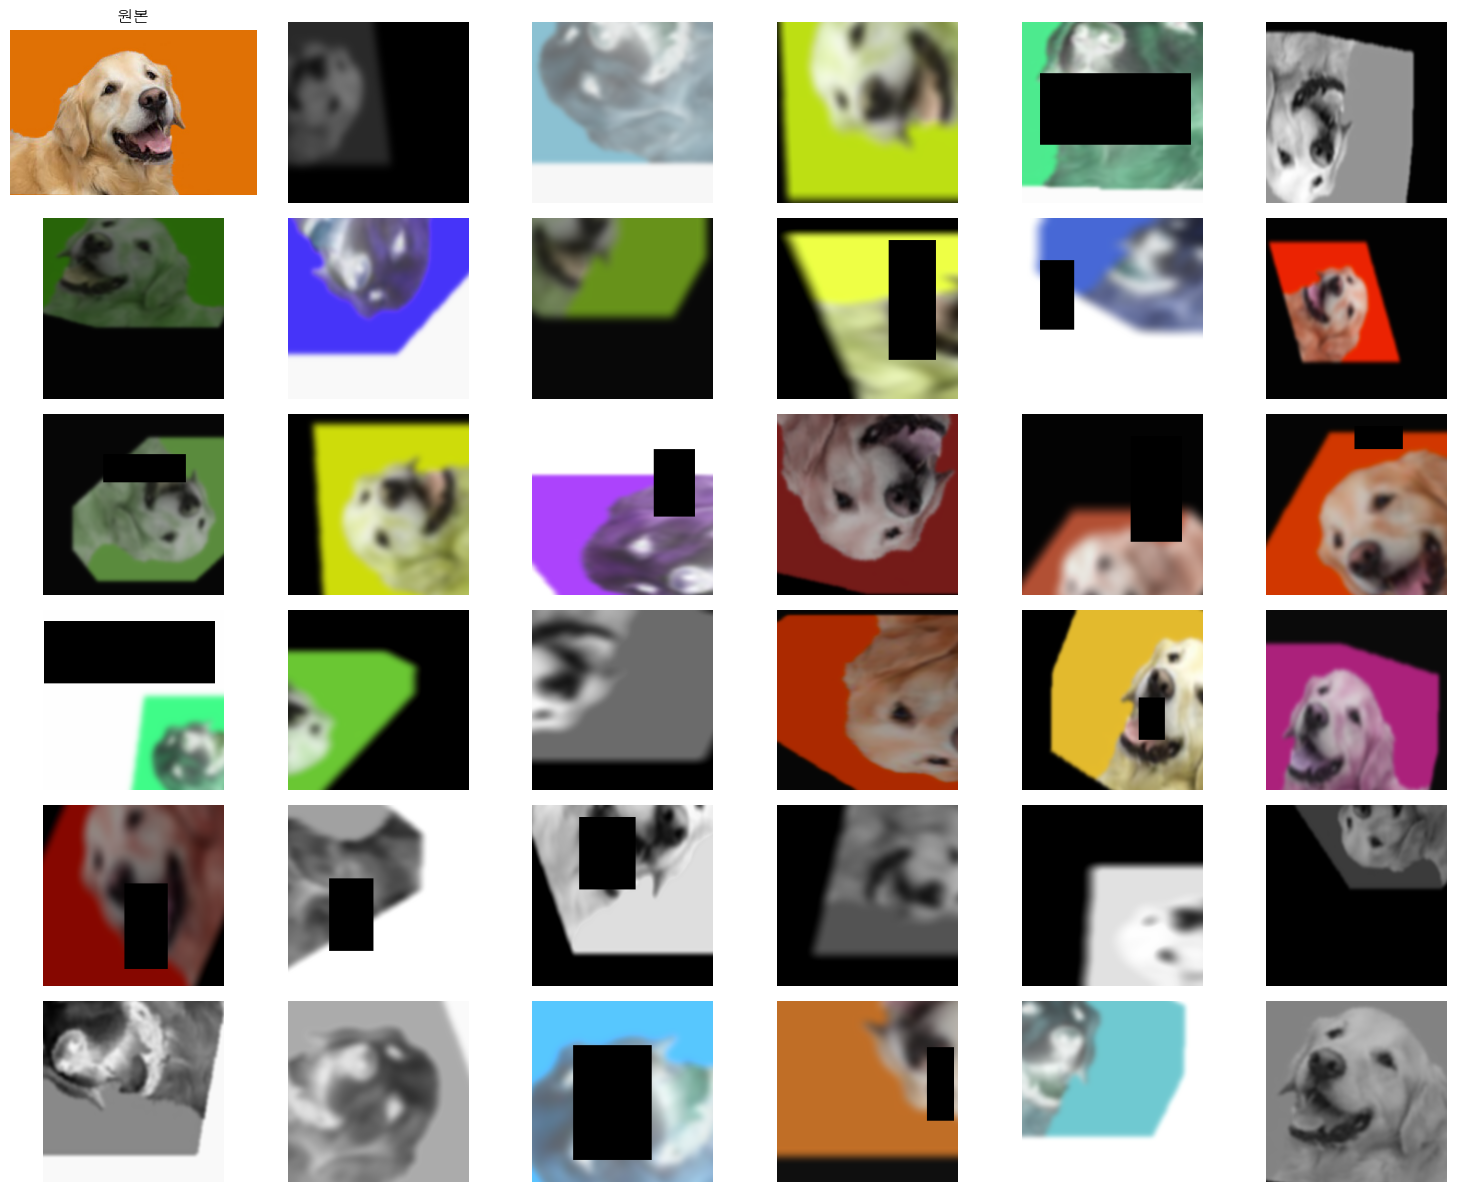

In [36]:

transform = transforms.Compose([
    transforms.ToTensor()
    ###########################
    # 좌우/상하 반전.           # p=확률, 50% 확률로 반전
    ###########################
    , transforms.RandomHorizontalFlip(p=0.5)  # HorizontalFlip은 좌우 반전
    , transforms.RandomVerticalFlip(p=0.5)    # VerticalFlip은 상하 반전
    
    ###########################
    # 회전
    ###########################
    , transforms.RandomRotation(degrees=180)  # -180~180도 사이에서 random하게 회전 (튜플로 지정하면 특정 각도 사이에서 random하게 회전)
    
    ###########################
    # affine 이동 변환들
    #  회전, 이동, 전단 변환 처리
    ###########################
    , transforms.RandomAffine(degrees=(0,0),        # 회전 각도 범위
                            translate=(0.1,0.3),    # 이동 범위
                            shear=(0.8, 1.2),       # 전단 변환 범위
                            scale=(0.5,1.2),        # 변환 후 크기 범위
                            )
    
    ###########################
    # 가우시안 블러
    ###########################
    , transforms.GaussianBlur(kernel_size=(17,17),  # 커널 사이즈 범위
                            sigma=(1, 5)            # 시그마 범위 (표준편차)
                            )       # 커널사이즈와 시그마는 커질수록 블러링 정도가 커진다.
    
    ########################### 
    # 선명도 (Sharpen)
    ###########################
    , transforms.RandomAdjustSharpness(sharpness_factor=5,  # 선명도 조절 범위 (1이 원본) (1미만은 블러링, 1초과는 선명도 증가)
                                        p=0.5,              # 확률
                                        ) 
    ###########################
    # 색관련 변환
    #  밝기, 대비, 채도, 색 변환 처리
    ###########################
    , transforms.ColorJitter(brightness=(0.5, 1.2), # 밝기 범위
                            contrast=(0.8, 1.2),    # 대비 범위
                            saturation=(0.5, 1.5),  # 채도 범위
                            hue=(-0.2, 0.2),        # 색상 범위
                            )
    
    #########################
    # Grayscale
    #########################
    , transforms.RandomGrayscale(p=0.15)    # 확률
    
    ############################
    # 반전 - 확률 지정할 수 있다.
    ############################
    , transforms.RandomInvert(p=0.2)
    
    
    ###########################
    # Center 영역 Crop
    ###########################
    # , transforms.CenterCrop(150)    # 지정한 크기로 중앙 영역을 Crop한다.
    #                                 # 150x150으로 Crop한다. (튜플로 지정하면 특정 크기로 Crop한다.)
    
    ############################
    # RandomCrop - Crop 영역을 random하게 선택한다.
    ############################
    # , transforms.RandomCrop(150)    # 지정한 크기로 random 위치에서 Crop한다.

    ###########################
    # RandomResizedCrop - Random한 영역을 Crop후 지정한 종횡비 resize 한다.
    ###########################
    , transforms.RandomResizedCrop(180,                 # Crop할 크기
                                    scale=(0.3, 0.7),   # Crop후 resize할 크기 범위 (1이 원본, 0.5는 50%)
                                    ratio=(0.5, 1.5)    # 종횡비 범위 (가로가 1일때 세로는 0.5~1.5 사이의 크기로 resize된다.)
                                    )
    ##############################
    # 이미지를 부분적으로 삭제한다. (픽셀값을 0으로 변경)
    # p=확률, scale=() 삭제 크기범위, ratio=() 삭제 종횡비 범위 => 지정된 튜플 비율에서 random 하게 선택되 변경됨
    # occlusion(폐색-가려지는 문제)문제에서의 한계를 해결. https://deepapple.tistory.com/8
    ###############################
    , transforms.RandomErasing()

])

img_path = 'test_img/dog.jpg'
image_show(img_path, transform)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


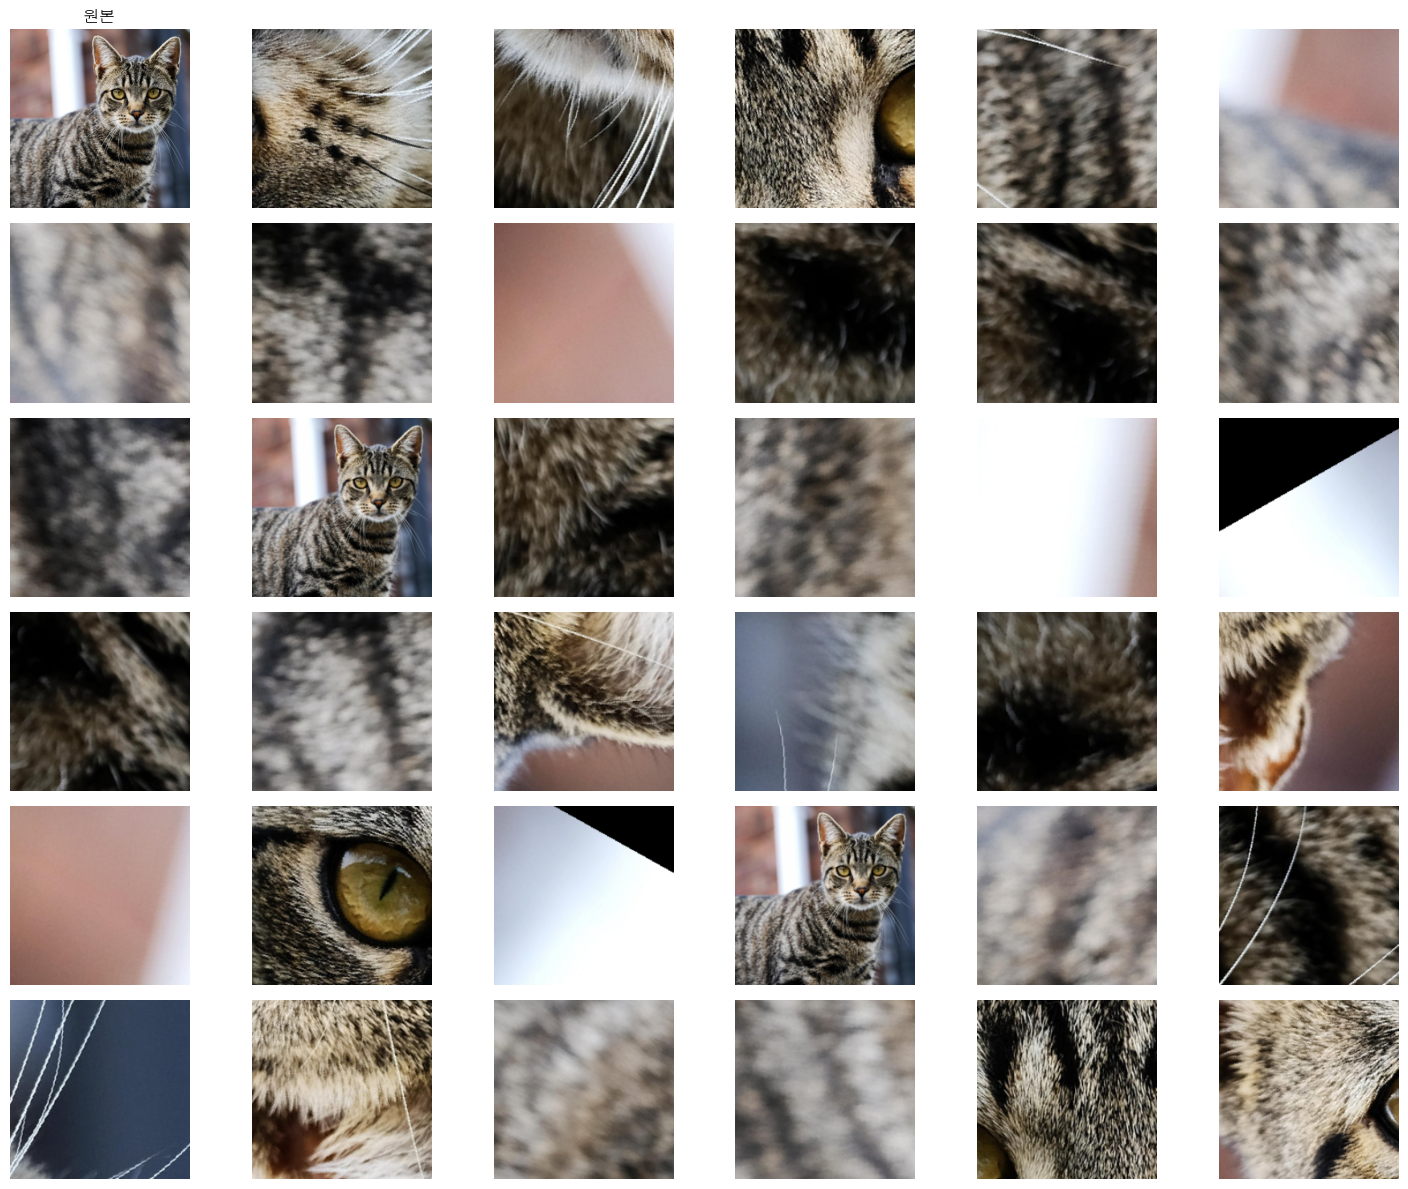

In [37]:

#####################################
# RandomApply() - 여러개 중 Random하게 여러개를 선택해서 적용한다. 선택 확률을 선택할 수 있다.
# RandomChoice() - 여러개 중 하나를 적용한다.
#####################################
transform2 = transforms.Compose([
    transforms.ToTensor()
    , transforms.RandomApply([              # 여러개를 각각 random하게 적용한다.
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(45), 
        transforms.RandomCrop((200,200)),
    ], p = 0.9)                             # 각각이 적용될 확률을 지정한다.
    , transforms.Resize((224, 224), antialias=True)
])

# transform2 = transforms.Compose([
#     transforms.ToTensor()
#     , transforms.RandomChoice([            # 여러개 중 하나를 적용한다.
#         transforms.RandomRotation(45), 
#         transforms.RandomHorizontalFlip(),
#         transforms.RandomVerticalFlip(),
#     ])
#     , transforms.Resize((224, 224), antialias=True)
# ])

image_show('test_img/cat.jpg', transform2)